# Simulating Stock Prices with Geometric Brownian Motion

In [25]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

## Setting up parameters

Geometric Brownian Motion is governed by the following Stochastic Differential Equation:

$dS = \mu S dt + \sigma S dW_t$

Here, $\mu$ denotes the drift (or the expected returns) of $S$. $\sigma$ denotes the standard deviation (or the volatility) of $S$. $W_t$ denotes a Brownian process. It has the follwoing property:

$W_0 = 0 \text{, and}$

$W_{t_1} - W_{t_2} \sim \mathscr{N}(0, t_1-t_2)$

At every instant in time, $S$ will be pushed along one deterministic direction due to $\mu$, and in another random direction due to $\sigma$

To simulate this behaviour, we need the values of $\mu$ and $\sigma$, along with the initial (starting) value of $S$.

In addition to this, we will need to specify a certain time-step - effectively, approximating like so:

$\Delta t \approx dt, \text{and}$

$\Delta W_t \approx dW_t$

Because of the property of Brownian Motion, we have

$\Delta W_t \sim \mathscr{N}(0, h)$

In [24]:
h = 0.001               # time-step
t = np.arange(0, 20, h) # time range
S0 = 100                # initial stock price
mu = 0.05               # stock price's expected returns
sigma = 0.07            # stock price's volatility

### Generating Noise

In [11]:
# Simulate a Brownian motion path
dw = np.random.normal(size=len(t)-1)*np.sqrt(h) # generating small elements of the Brownian Process
W = np.insert(np.cumsum(dw), 0, 0)              # The whole Brownian Process must be continuous, hence adding up elements

### Simulating Stock Price movement - analytically and numerically

The Stochastic Differential Equation for Geometric Brownian Motion is mentioned above. It can be solved analytically to yield:

$S = S_0\exp\left(\mu t - \frac{\sigma^2}{2}t + \mathscr{N}(0, \sigma^2t)\right)$

This will serve as our reference. If we know the noise values $W_t$ exactly for all $t$, we should be able to exactly predict the movement of the stock. But of course, that's not the case.

What we can do is simulate our own noise with the known statistics.

Each set of noise values will give a unique path for the stock price. We can then observe the distribution of all possible paths empirically and make a note of the mean and the top- and bottom- 5 percentiles.

We already know the expected value :

$\mathbb{E}(S) = S_0\exp\left(\mu t\right)$

The mean we calculated earlier should align with that.

In [16]:
# ANALYTIC SOLUTION
S = S0*np.exp((mu-((sigma**2)/2))*t)*np.exp(W*sigma) # Closed-form solution of Geometric Brownian Motion

# NUMERICAL SOLUTION
no_trials = 2000
S_est = np.zeros([no_trials, len(S)])


S_est[:,0] = S0    # all simulated paths have the same starting point
dw2 = np.random.normal(scale=np.sqrt(h), size=(no_trials, len(t)-1)) # noise is generated newly for each simulation
for j in range(1, len(t)):
    S_est[:,j] = S_est[:,j-1]+(mu*S_est[:,j-1]*h)+(sigma*S_est[:,j-1]*dw2[:,j-1]) # solving SDE using Euler-Maruyama method

S_noiseless = S0*np.exp(mu*t) # long-run expected behaviour of the stock price is to grow at the rate of 'u'
                            
S_est_mean = np.mean(S_est, axis=0) # Expected behaviour of stock price as obtained from sims
lower_5 = np.percentile(S_est,  5, axis=0) # worst 5% paths
upper_5 = np.percentile(S_est, 95, axis=0) # best 5% paths

### Plotting Simulation Results

WARNING!! This takes a while to run if no_trials is large.

Consider plotting every 10th path if we're doing 2000 total sims.

Here's every path taken by the stock price is graphed out over time. Each plot is translucent so that we can observe which areas are denser and which ones are less likely to happen. The mean (calculated) and the mean (from sims) are also plotted, along with markers for the top-5 percentile and the bottom-5 percentile.

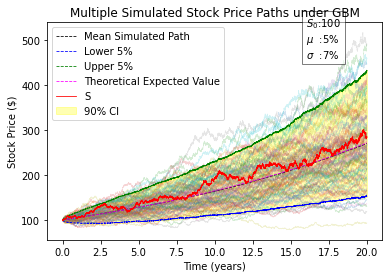

In [63]:
%matplotlib inline
l = 0.8

for i in range(int(no_trials//20)):
    plt.plot(t, S_est[i*20], linewidth=0.5, alpha=0.2)
plt.plot(t, S_est_mean, linewidth=l, label='Mean Simulated Path', color='black', linestyle='--')
plt.plot(t, lower_5, linewidth=l, label='Lower 5%', color = 'blue', linestyle='--')
plt.plot(t, upper_5, linewidth=l, label='Upper 5%', color = 'green', linestyle='--')
plt.fill_between(t, lower_5, upper_5, color='yellow', alpha=0.3, label="90% CI")
plt.plot(t, S_noiseless, linewidth=l, label='Theoretical Expected Value', color = 'magenta', linestyle='--')
plt.plot(t, S, linewidth=l, color='red', label="S")
plt.legend()
plt.ylabel('Stock Price ($)')
plt.xlabel('Time (years)')

plt.text(
    16,
    460,
    f"$S_0$:{S0}\n$\mu$  :{100*mu:.0f}%\n$\sigma$  :{100*sigma:.0f}%",
    fontsize=10,
    color="black",
    bbox=dict(facecolor="white", alpha=0.5),
)
plt.title("Multiple Simulated Stock Price Paths under GBM")
plt.show()

### Analyzing the Probability Distribution 

In the previous block, we plotted the paths that the stock price could take and visually saw areas of more and less likelihood. But this is only qualitative. We would like to take a more quantitative route, so we can plot a histogram of the stock price at any point in time.

Since we know the analytic solution, we can also fit an 'ideal' curve around the histogram.

We know that $S = S_0\exp\left(\mu t - \frac{\sigma^2}{2}t + \mathscr{N}(0, \sigma^2t)\right)$

This means that it will follow a log-normal distribution.

We can find the p.d.f of $S$ using the transformation of variables.

This comes out to be a complicated expression, as so:

$\mathbb{P}(S) = \frac{\exp\left( - \frac{\left(\ln\left( \frac{S}{S_0} \right) - \mu t + \frac{\sigma^2}{2}t\right)^2}{2*\sigma^2t} \right)}{\sqrt{2 \pi \sigma^2 t}} \cdot \frac{1}{S}$

This equation is difficult to intuitively grasp, but it becomes more obvious once we plot in alongside the histogram.

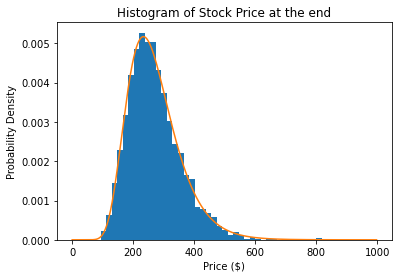

In [64]:
def get_distrib(S0, mu, sigma, t):
    '''
    simple function to get the distribution of the stock price at any time 't'
    S0    : initial stock price
    mu    : expected returns (drift)
    sigma : volatility
    t     : time instant
    '''
    c = S0*np.exp((mu-((sigma**2)/2))*t)
    x = np.arange(1,10*S0)
    p = np.log(x/c)
    return (1/np.sqrt(2*np.pi*sigma*sigma*t))*np.exp(-((p*p)/(2*sigma*sigma*t)))*(1/x)

plt.hist(S_est[:, -1], bins=40, density=True)
plt.plot(get_distrib(S0, mu, sigma, t[-1]))
plt.xlabel('Price ($)')
plt.ylabel('Probability Density')
plt.title('Histogram of Stock Price at the end')
plt.show()